<a href="https://colab.research.google.com/github/cristianofranco76/DataScienceSpCourseNotes/blob/master/FIltro_AntiSpam_SMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de TCC: Filtros de alta precisão e performance para mensagens de SMS fraudulentas com base em redes neurais

Este trabalho explora:
1) as estratégias e os desafios enfrentados na luta contra o smishing
2) tipos de fraudes mais comuns e suas características e
3) a implementação de medidas eficazes para detectar SMS fraudulentos.

O objetivo é criar um filtro de SMS de alta precisão e baixo consumo computacional, explorando algoritmos de aprendizado profundo e considerando base de dados com e sem mensagens spams, gerando maior acuracidade no bloqueio de disparos massivos que podem prejudicar usuários e melhorando a performance de entrega de campanhas para clientes idôneos.

Como a forma de gerar maior impacto nos usuários finais é por meio da utilização de URLs. O algorítimo do filtro foca na classificaÇão das URLs enviadas nas mensagens de SMS, extraindo caracteristicas dessas URLs para serem classificadas por meio de treinamento de algoritimos de ML supervisionados e semi-supervisionados.


# **Importando Bibliotecas importantes**

In [2]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import re
import spacy
import matplotlib.pyplot as plt
import math
from spacy import prefer_gpu, require_gpu

!pip install urlextract
from urlextract import URLExtract

!pip install wordcloud
import wordcloud

!pip install validators
!pip install dask
import nltk
import validators
import dask.dataframe as dd
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from urllib.parse import urlparse, parse_qs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 805.1 kB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
prefer_gpu()
print("spaCy está usando GPU:", spacy.prefer_gpu())

spaCy está usando GPU: False


# Passo 0 - **Leitura dos Arquivos de Dados**

In [3]:
#Função para ler os arquivos CSV contendo as mensagens de SMS

def read_csv(file_path):
    try:
        # Lendo o arquivo CSV com quebra de linha como delimitador
        with open(file_path, 'r', encoding='utf-8') as file:
            # Lê o arquivo inteiro e divide em linhas
            content = file.read().strip().split('\n')

        # Converte as linhas em um DataFrame
        df = pd.DataFrame(content, columns=['message'])

        print(f"Arquivo '{file_path}' lido com sucesso.")
        return df

    except Exception as e:
        print(f"Erro ao ler o arquivo '{file_path}': {e}")
        return pd.DataFrame()

# Camninhos dos arquivos para leitura
from google.colab import drive
drive.mount('/content/drive')
file1 = '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/messages_unblock.csv'
file2 = '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/messages_block.csv'

# Leitura dos arquivos CSV
df_ham  = read_csv(file1)
df_spam = read_csv(file2)

Mounted at /content/drive
Arquivo '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/messages_unblock.csv' lido com sucesso.
Arquivo '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/messages_block.csv' lido com sucesso.


# PASSO 1 - Tratamento dos dados

## Insere Label nas mensagens

In [4]:
#Inserindo o Label
df_ham.insert(1, 'label', 'ham')
df_spam.insert(1, 'label', 'spam')

# Unificando os Datasets
df_combined = pd.concat([df_ham, df_spam], ignore_index=True)

#embaralhando o dataset
#df_combined = df_combined.sample(frac=1).reset_index(drop=True)

## Coloca todas as mensagens em Lowercase

In [5]:
# Função para colocar os textos em lowercase
def to_lowercase(text):
    return text.lower()

#Aplicar a função de conversão para minúsculas
df_combined['message'] = df_combined['message'].apply(to_lowercase)

## Salva o dataset combinado e com labels em "dataset_combinado.csv"

In [6]:
# Salvando dataset em um arquivo combinado
output_file_path = '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/dataset_combinado.csv'
df_combined.to_csv(output_file_path, index=False)
print(f"Dataset unificado salvo em '{output_file_path}'.")

Dataset unificado salvo em '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/dataset_combinado.csv'.


## Extrai a URL das Mensagens

In [9]:
import multiprocessing as mp

# Carregar o dataset
file_path = '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/dataset_combinado.csv'
df_combined = pd.read_csv(file_path)

# Inicializar o extrator de URLs
extractor = URLExtract()

# Função para extrair URLs usando URLExtract
def extract_urls(text):
    return extractor.find_urls(text)

# Paralelizar a aplicação da função de extração de URLs
with mp.Pool(mp.cpu_count()) as pool:
    df_combined['extracted_urls'] = pool.map(extract_urls, df_combined['message'])

# Contar a quantidade de URLs e adicionar ao DataFrame
df_combined['num_urls'] = df_combined['extracted_urls'].apply(len)

# Adicionar colunas para cada URL encontrada
max_urls = df_combined['num_urls'].max()
for i in range(max_urls):
    df_combined[f'URL_{i+1}'] = df_combined['extracted_urls'].apply(lambda urls: urls[i] if i < len(urls) else None)

# Excluir a coluna 'extracted_urls'
df_combined.drop('extracted_urls', axis=1, inplace=True)

## Salva o dataset combinado com as URLs encontradas em "dataset_urls.csv"

In [11]:
# Salvando dataset em um arquivo
output_file_path = '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/dataset_urls.csv'
df_combined.to_csv(output_file_path, index=False)
print(f"Dataset unificado salvo em '{output_file_path}'.")

# Contar a quantidade de mensagens por número de URLs e por tipo de label
url_label_counts = df_combined.groupby(['label', 'num_urls']).size().unstack(fill_value=0)

# Exibir a contagem de mensagens por número de URLs e por tipo de label
print("Contagem de mensagens por número de URLs e por tipo de label:")
print(url_label_counts)

Dataset unificado salvo em '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/dataset_urls.csv'.


# Passo 1.1 Le arquivo com URLs e Elimina as tuplas com nenhuma URL

In [6]:
# Carregar o dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/00_TCC IA/Arquivos de dados/dataset_urls.csv'
df_combined = pd.read_csv(file_path)

# Função para limpar tuplas com 0 URLs
def clean_zero_url_rows(df):
    return df[df['num_urls'] > 0]

# Aplicar a função de limpeza
df_combined = clean_zero_url_rows(df_combined)

# Contar a quantidade de mensagens por número de URLs e por tipo de label
url_label_counts = df_combined.groupby(['label', 'num_urls']).size().unstack(fill_value=0)
# Exibir a contagem de mensagens por número de URLs e por tipo de label
print("Contagem de mensagens por número de URLs e por tipo de label:")
print(url_label_counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-6-7da20f3b7056>:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv(file_path)


Contagem de mensagens por número de URLs e por tipo de label:
num_urls       1      2   3
label                      
ham       661608  36339  46
spam      257832  15164   4


# Passo 2 - Gera uma amostra de dados balanceada (ham/spam) - amostra_sms

In [18]:
def gera_amostra_sms(df, sample_size):
    # Verifica se a quantidade de mensagens "Spam" no dataframe é suficiente
    num_spam = len(df[df['label'] == 'spam'])
    if sample_size // 2 > num_spam:
        raise ValueError(f"O número de amostras solicitadas excede a quantidade de mensagens Spam disponíveis ({num_spam}).")

    # Verifica se a quantidade de mensagens "Ham" no dataframe é suficiente
    num_ham = len(df[df['label'] == 'ham'])
    if sample_size // 2 > num_ham:
        raise ValueError(f"O número de amostras solicitadas excede a quantidade de mensagens Ham disponíveis ({num_ham}).")

    # Gera amostras aleatórias de mensagens Ham e Spam
    ham_sample = df[df['label'] == 'ham'].sample(n=sample_size // 2, random_state=1)
    spam_sample = df[df['label'] == 'spam'].sample(n=sample_size // 2, random_state=1)

    # Concatena as amostras de Ham e Spam para formar o dataframe de amostra final
    sample_df = pd.concat([ham_sample, spam_sample]).sample(frac=1, random_state=1).reset_index(drop=True)

    return sample_df

#embaralhando o dataset
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

#gera uma amostra do dataset
amostra_sms = gera_amostra_sms(df_combined, 50000)

# Contar o número de mensagens contendo os labels 'ham' e 'spam'
label_counts = amostra_sms['label'].value_counts()

# Exibir a contagem de mensagens por label
print("Contagem de mensagens da amostra por label:")
print(label_counts)

Contagem de mensagens da amostra por label:
label
spam    25000
ham     25000
Name: count, dtype: int64


# **Passo 3 - Exploração da amostra do Dataset (opcional)**

In [5]:
# Contagem de caracteres em 'message'
amostra_sms['char'] = amostra_sms['message'].str.len()

# Funções de tokenização
def count_words(message):
    return len(nltk.word_tokenize(message))

def count_sentences(message):
    return len(nltk.sent_tokenize(message))

# Aplicação das funções de tokenização
amostra_sms['word'] = amostra_sms['message'].map(count_words)
amostra_sms['sentence'] = amostra_sms['message'].map(count_sentences)

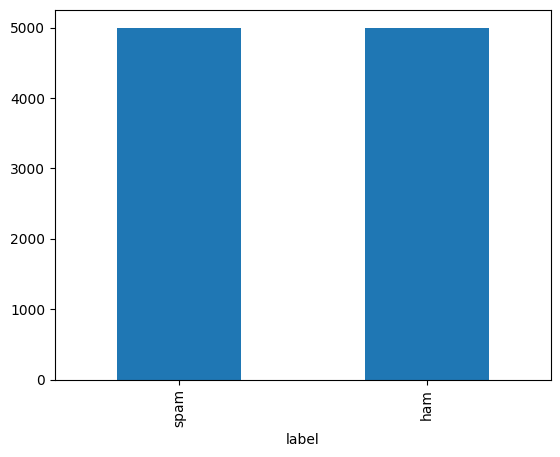

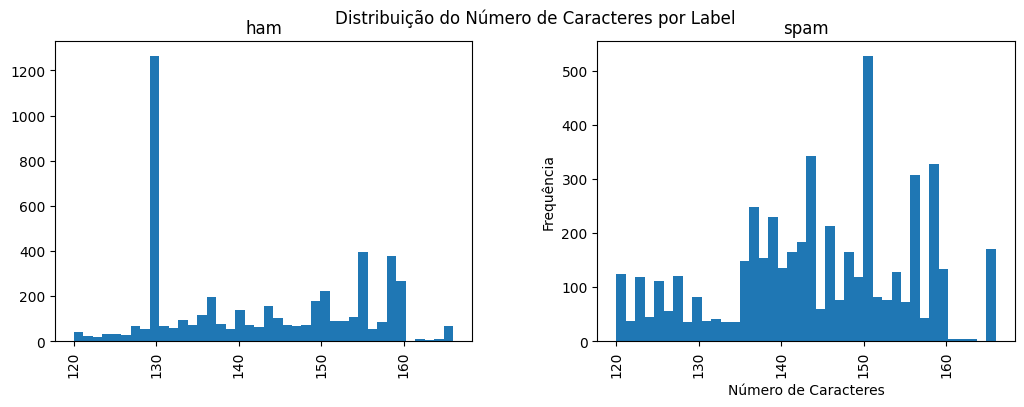

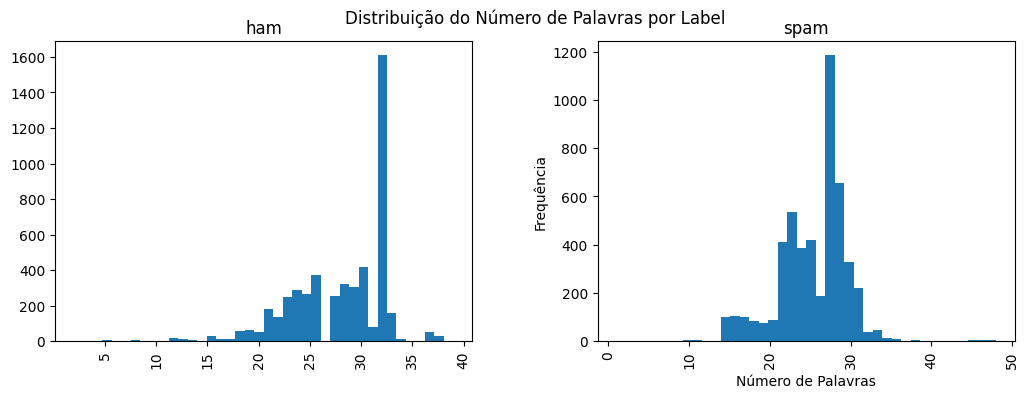

In [6]:
amostra_sms.label.value_counts().plot.bar();

# Histograma do número de caracteres por label
amostra_sms.hist(column='char', by='label', bins=40, figsize=(12, 4))
plt.suptitle("Distribuição do Número de Caracteres por Label")
plt.xlabel("Número de Caracteres")
plt.ylabel("Frequência")
plt.show()

# Histograma do número de palavras por label
amostra_sms.hist(column='word', by='label', bins=40, figsize=(12, 4))
plt.suptitle("Distribuição do Número de Palavras por Label")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.show()

In [7]:
print(amostra_sms.head())

                                             message label  num_urls  \
0  050003b20403|https://npa.digital/?n=2721167361...  spam         1   
1  [betvip] voce ganhou saldo real! deposite r$20...   ham         1   
2  wagner, cpf: 0566.xxx.xxx-99 seu debito pernam...   ham         1   
3  goldebet: leiva ative a sua sorte. recarregue ...   ham         1   
4  1746 - seu protocolo rio-28698496-0 foi fechad...  spam         2   

                                   URL_1                    URL_2 URL_3  char  \
0  https://npa.digital/?n=2721167361567.                      NaN   NaN   142   
1                  https://smr4.cc/hfn04                      NaN   NaN   130   
2             tdju.net/n.php?i=s15620580                      NaN   NaN   150   
3              https://gsite.cc/2eadfca4                      NaN   NaN   132   
4             https://bit.ly/1746android  https://apple.co/2kr...   NaN   150   

   word  sentence  
0    24         2  
1    32         3  
2    24         2  


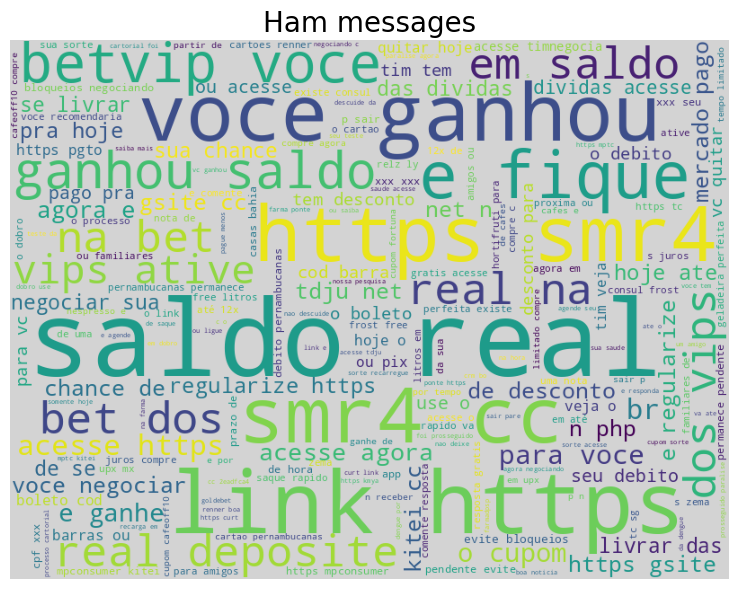

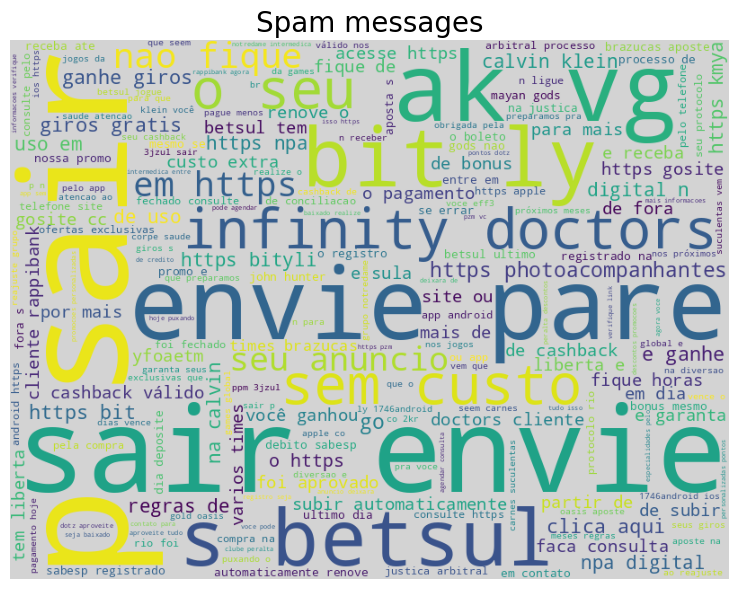

In [8]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)

    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)

    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

data_ham  = amostra_sms[amostra_sms['label'] == 'ham'].copy()
show_wordcloud(data_ham, "Ham messages")

data_spam  =  amostra_sms[amostra_sms['label'] == 'spam'].copy()
show_wordcloud(data_spam, "Spam messages")

# Passo 4 - Extração de Features

## Função para extrair as features de cada URL

In [19]:
# Função de extração de features
def extract_features(url):
    if pd.isna(url):
        return {}

    features = {}
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname if parsed_url.hostname else ""
    path = parsed_url.path if parsed_url.path else ""
    query = parsed_url.query if parsed_url.query else ""

    # Basic features
    features['url_length'] = len(url) #1
    features['num_words'] = len(re.findall(r'\w+', url)) #2
    features['num_digits'] = len(re.findall(r'\d', url)) #3
    features['num_ampersands'] = url.count('&') #4
    features['num_sensitive_words'] = sum(word in url for word in ['login', 'signup', 'admin']) #5
    features['num_at_symbol'] = url.count('@') #6
    features['num_special_chars'] = len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', url)) #7
    features['num_punctuation'] = len(re.findall(r'[.,;:]', url)) #8
    features['num_dots_subdomain'] = hostname.count('.') - 1 #9
    features['num_tld_paths'] = len(re.findall(r'\.[a-z]{2,3}\/', url)) #10
    features['num_subdomains'] = len(hostname.split('.')) - 1 if hostname else 0 #11
    features['num_digits_host'] = len(re.findall(r'\d', hostname)) #12
    features['num_dots'] = url.count('.') #13
    features['num_words_host'] = len(re.findall(r'\w+', hostname)) #14
    features['num_hyphens_path'] = path.count('-') #15
    features['num_double_hyphens'] = url.count('--') #16
    features['num_underscore'] = url.count('_') #17
    features['num_dots_host'] = hostname.count('.') #18
    features['num_dots_path'] = path.count('.') #19
    features['num_hyphens_host'] = hostname.count('-') #20
    features['num_uppercase'] = sum(1 for c in url if c.isupper()) #21
    features['num_repeated_chars'] = len(re.findall(r'(.)\1{2,}', url)) #22
    features['num_letter_number_sequences'] = len(re.findall(r'[a-zA-Z]\d|\d[a-zA-Z]', url)) #23

    # Boolean features (Has)
    features['has_https_protocol'] = url.startswith('https://') #24
    features['has_ip_address'] = bool(re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', hostname)) #25
    features['has_www'] = 'www' in hostname #26
    features['has_query'] = bool(query) #27
    features['has_redirect'] = '//' in url[7:] #28
    features['has_suffix'] = bool(re.search(r'\.[a-z]{2,3}$', url)) #29
    features['has_sensitive_words'] = any(word in url for word in ['login', 'signup', 'admin']) #30
    features['has_at_symbol'] = '@' in url #31
    features['has_tld'] = re.search(r'\.[a-z]{2,3}$', hostname) is not None #32
    features['has_hyphen_url'] = '-' in url #33

    # Length features
    features['length_path'] = len(path) #34
    features['length_subdomain'] = len(hostname.split('.')[0]) if hostname else 0 #35
    features['length_url_path'] = len(parsed_url.path) #36
    features['length_domain_name'] = len(hostname.split('.')[1]) if len(hostname.split('.')) > 1 else 0 #37
    features['length_longest_word'] = max([len(word) for word in re.findall(r'\w+', url)], default=0) #38
    features['length_shortest_word'] = min([len(word) for word in re.findall(r'\w+', url)], default=0) #39
    features['length_longest_word_hostname'] = max([len(word) for word in hostname.split('.')], default=0) if hostname else 0 #40
    features['length_avg_word'] = sum([len(word) for word in re.findall(r'\w+', url)]) / len(re.findall(r'\w+', url)) if re.findall(r'\w+', url) else 0 #41
    features['length_ratio_vowel_consonant'] = len(re.findall(r'[aeiou]', url)) / (len(re.findall(r'[^aeiou\s\d\W]', url)) or 1) #42
    features['length_ratio_digit_letter'] = len(re.findall(r'\d', url)) / (len(re.findall(r'[a-zA-Z]', url)) or 1) #43
    features['length_ratio_longest_shortest'] = (max([len(word) for word in re.findall(r'\w+', url)], default=0) / (min([len(word) for word in re.findall(r'\w+', url)], default=1) or 1))#44
    features['length_std_words'] = (lambda words: (sum((len(word) - (sum(len(word) for word in words) / len(words))) ** 2 for word in words) / len(words)) ** 0.5 if words else 0)(re.findall(r'\w+', url)) #45

    # Ratio features
    features['ratio_url_path'] = len(url) / (len(path) or 1) #46
    features['ratio_host_path'] = len(hostname) / (len(path) or 1) #47
    features['ratio_host_query'] = len(hostname) / (len(query) or 1) #48

    # Additional features
    features['length_parameters'] = len(query) #49
    features['port_number'] = parsed_url.port if parsed_url.port else -1 #50

    return features

# Aplicar extração de features ao dataset
def create_features_vector(df, url_columns):
    def combine_features(row):
        features_vector = []
        for col in url_columns:
            if pd.notna(row[col]):
                features_vector.append(extract_features(row[col]))
        return features_vector

    df['url_features'] = df.apply(combine_features, axis=1)
    return df

## Extraindo as features das URLs do Dataset

In [20]:
# Aplicar a extração de features e criar a coluna de vetor de features
url_columns = ['URL_1', 'URL_2', 'URL_3']
amostra_sms = create_features_vector(amostra_sms, url_columns)

## Criando o dataset com label e features para filtro classificador

In [21]:
# Função para extrair as características das URLs e a label de cada linha
def extract_features(dataframe):
    extracted_data = []

    for _, row in dataframe.iterrows():
        label = row['label']
        features_list = ast.literal_eval(row['url_features']) if isinstance(row['url_features'], str) else row['url_features']

        for feature in features_list:
            data_entry = {'label': label}
            data_entry.update(feature)
            extracted_data.append(data_entry)

    return extracted_data

# Extrair as características
extracted_features = extract_features(amostra_sms)

# Converter para DataFrame
features_df = pd.DataFrame(extracted_features)

features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
url_length,52673.0,25.940349,10.250871,4.0,21.000000,25.000000,28.000000,160.000000
num_words,52673.0,4.458166,1.182777,2.0,4.000000,4.000000,5.000000,27.000000
num_digits,52673.0,3.086857,4.224163,0.0,1.000000,2.000000,4.000000,88.000000
num_ampersands,52673.0,0.002506,0.060950,0.0,0.000000,0.000000,0.000000,5.000000
num_sensitive_words,52673.0,0.000589,0.024253,0.0,0.000000,0.000000,0.000000,1.000000
num_at_symbol,52673.0,0.000418,0.020433,0.0,0.000000,0.000000,0.000000,1.000000
num_special_chars,52673.0,2.207545,0.828276,1.0,2.000000,2.000000,3.000000,21.000000
num_punctuation,52673.0,2.126573,0.755739,1.0,2.000000,2.000000,2.000000,7.000000
num_dots_subdomain,52673.0,-0.135250,0.703614,-1.0,-1.000000,0.000000,0.000000,4.000000
num_tld_paths,52673.0,0.887096,0.316479,0.0,1.000000,1.000000,1.000000,1.000000


In [22]:
features_df.head()

,label,url_length,num_words,num_digits,num_ampersands,num_sensitive_words,num_at_symbol,num_special_chars,num_punctuation,num_dots_subdomain,...,length_avg_word,length_ratio_vowel_consonant,length_ratio_digit_letter,length_ratio_longest_shortest,length_std_words,ratio_url_path,ratio_host_path,ratio_host_query,length_parameters,port_number
0,spam,22,4,0,0,0,0,2,2,0,...,4.25,0.062500,0.000000,4.0,2.487469,2.444444,0.555556,5.0,0,-1
1,spam,37,5,0,0,0,0,2,2,0,...,6.20,0.409091,0.000000,9.0,5.979967,5.285714,3.142857,22.0,0,-1
2,spam,22,4,0,0,0,0,1,1,-1,...,4.75,0.583333,0.000000,5.0,3.112475,1.000000,0.000000,0.0,0,-1
3,ham,21,4,3,0,0,0,2,2,0,...,4.00,0.000000,0.230769,2.5,1.224745,3.500000,1.166667,7.0,0,-1
4,ham,21,4,5,0,0,0,2,2,0,...,4.00,0.100000,0.454545,2.5,1.224745,3.500000,1.166667,7.0,0,-1


# Passo 5 - Treinamento, teste e avaliação dos modelos do filtro

In [ ]:
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# Separar as características (X) e os rótulos (y)
X = features_df.drop(columns=['label'])
y = features_df['label'].apply(lambda x: 1 if x == 'spam' else 0)  # Converter rótulos para binário

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balanceamento dos dados
# Combinar X_train e y_train para balanceamento
train_data = pd.concat([X_train, y_train], axis=1)

# Separar classes majoritárias e minoritárias
spam = train_data[train_data['label'] == 1]
ham = train_data[train_data['label'] == 0]

# Aumentar a classe minoritária
spam_upsampled = resample(spam, replace=True, n_samples=len(ham), random_state=42)

# Combinar novamente classes balanceadas
upsampled_train_data = pd.concat([ham, spam_upsampled])

# Separar novamente em X_train e y_train
X_train = upsampled_train_data.drop(columns=['label'])
y_train = upsampled_train_data['label']

# Escalar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Função para avaliar um modelo
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=1),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A',
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }
    return metrics

# Função para plotar a matriz de confusão
def plot_confusion_matrices(metrics_dict):
    num_models = len(metrics_dict)
    num_cols = 3
    num_rows = (num_models + num_cols - 1) // num_cols  # Calcula o número de linhas necessárias

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

    # Flatten the axes array for easy iteration if there are multiple rows
    axes = axes.flatten()

    for ax, (model_name, metrics) in zip(axes, metrics_dict.items()):
        cm = metrics['Confusion Matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        ax.title.set_text(f'Confusion Matrix for {model_name}')

        # Annotate the matrix with TP, TN, FP, FN
        tn, fp, fn, tp = cm.ravel()
        ax.text(0, 0, f'TN = {tn}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.text(1, 1, f'TP = {tp}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.text(0, 1, f'FP = {fp}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.text(1, 0, f'FN = {fn}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))

    # Hide any unused subplots
    for i in range(len(metrics_dict), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Lista de modelos para treinar e avaliar
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Aumentar max_iter
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(),
    'Extra Trees': ExtraTreesClassifier()
}

# Dicionário para armazenar as métricas de cada modelo
metrics_dict = {}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Usar dados escalados
    metrics = evaluate_model(model, X_test_scaled, y_test)  # Usar dados escalados
    metrics_dict[model_name] = metrics

# Converter o dicionário de métricas para DataFrame para as métricas escalares
metrics_df = pd.DataFrame({k: {sk: sv for sk, sv in v.items() if sk != 'Confusion Matrix'} for k, v in metrics_dict.items()}).T

# Imprimir o DataFrame de métricas escalares
print(metrics_df)

# Plotar as matrizes de confusão lado a lado
plot_confusion_matrices(metrics_dict)

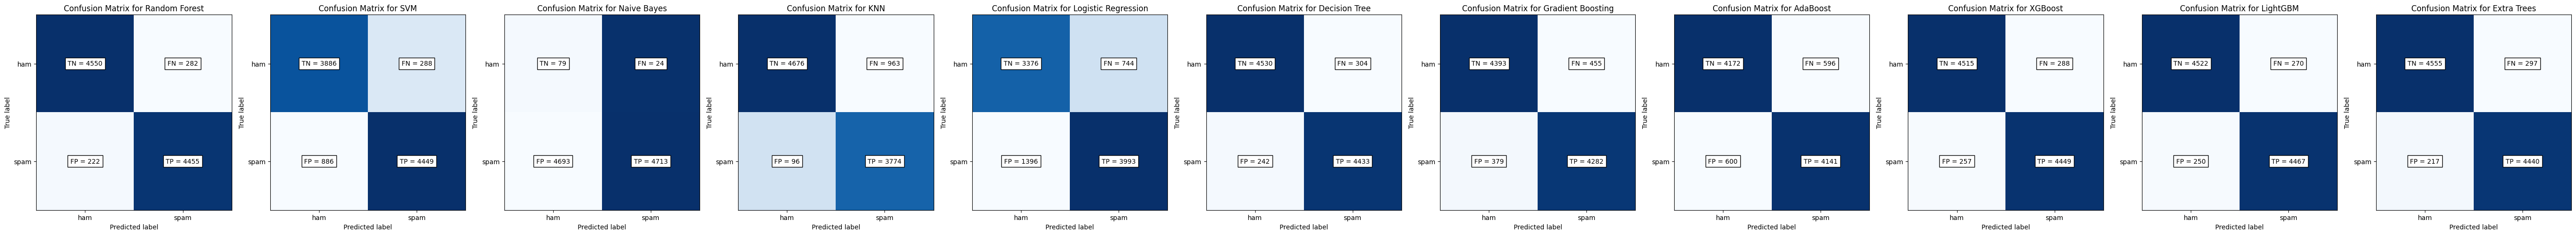

In [17]:
import ast
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

# Função para plotar a matriz de confusão
def plot_confusion_matrices(metrics_dict):
    num_models = len(metrics_dict)
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 5))

    if num_models == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    for ax, (model_name, metrics) in zip(axes, metrics_dict.items()):
        cm = metrics['Confusion Matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        ax.title.set_text(f'Confusion Matrix for {model_name}')

        # Annotate the matrix with TP, TN, FP, FN
        tn, fp, fn, tp = cm.ravel()
        ax.text(0, 0, f'TN = {tn}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.text(1, 1, f'TP = {tp}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.text(0, 1, f'FP = {fp}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.text(1, 0, f'FN = {fn}', ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))

    plt.tight_layout()
    plt.show()

# Plotar as matrizes de confusão lado a lado
plot_confusion_matrices(metrics_dict)

## Rede Neural com tokenizador para URL

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pydot
import graphviz

data = amostra_sms

# Concatenar as colunas URL_1, URL_2 e URL_3 em uma única string para cada linha
urls = data[['URL_1', 'URL_2', 'URL_3']].astype(str).agg(' '.join, axis=1).values
labels = data['label'].apply(lambda x: 1 if x == 'spam' else 0)  # Converter rótulos para binário

# Garantir que as labels estão no formato numérico
labels = labels.astype(np.float32)

# Dividir os dados em treino e teste
urls_train, urls_test, labels_train, labels_test = train_test_split(urls, labels, test_size=0.3, random_state=42)

# Tokenização de caracteres
tokenizer = Tokenizer(char_level=True, num_words=10000)
tokenizer.fit_on_texts(urls_train)
urls_train_seq = tokenizer.texts_to_sequences(urls_train)
urls_test_seq = tokenizer.texts_to_sequences(urls_test)

# Padding das sequências
max_len = 200  # URLs podem ser longas, ajuste conforme necessário
urls_train_seq_pad = pad_sequences(urls_train_seq, maxlen=max_len)
urls_test_seq_pad = pad_sequences(urls_test_seq, maxlen=max_len)

# Construção da Rede Neural
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compilação do Modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento do Modelo
history = model.fit(urls_train_seq_pad, labels_train, epochs=15, batch_size=32, validation_split=0.2)

# Avaliação do Modelo
loss, accuracy = model.evaluate(urls_test_seq_pad, labels_test)
predictions = (model.predict(urls_test_seq_pad) > 0.5).astype("int32")

# Relatório de Classificação
report = classification_report(labels_test, predictions, target_names=['ham', 'spam'])
conf_matrix = confusion_matrix(labels_test, predictions)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)


Epoch 1/15
350/350 [==============================] - 14s 31ms/step - loss: 0.5216 - accuracy: 0.7420 - val_loss: 0.4193 - val_accuracy: 0.8279
Epoch 2/15
350/350 [==============================] - 7s 21ms/step - loss: 0.3776 - accuracy: 0.8428 - val_loss: 0.3120 - val_accuracy: 0.8861
Epoch 3/15
350/350 [==============================] - 9s 26ms/step - loss: 0.2743 - accuracy: 0.8979 - val_loss: 0.2448 - val_accuracy: 0.9082
Epoch 4/15
350/350 [==============================] - 8s 22ms/step - loss: 0.2370 - accuracy: 0.9126 - val_loss: 0.2160 - val_accuracy: 0.9200
Epoch 5/15
350/350 [==============================] - 8s 21ms/step - loss: 0.2052 - accuracy: 0.9262 - val_loss: 0.2083 - val_accuracy: 0.9293
Epoch 6/15
350/350 [==============================] - 4s 12ms/step - loss: 0.2058 - accuracy: 0.9262 - val_loss: 0.1906 - val_accuracy: 0.9321
Epoch 7/15
350/350 [==============================] - 6s 17ms/step - loss: 0.1843 - accuracy: 0.9344 - val_loss: 0.1849 - val_accuracy: 0.932

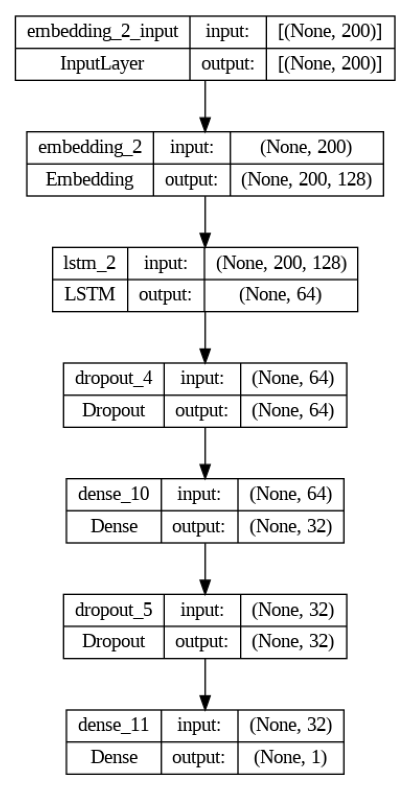

In [49]:
# Visualização da Rede Neural
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Exibir a imagem da rede neural
img = plt.imread('model.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

## Rede Neural utilizando as features extraidas da URL

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Separar as características (X) e os rótulos (y)
X = features_df.drop(columns=['label'])
y = features_df['label'].apply(lambda x: 1 if x == 'spam' else 0)  # Converter rótulos para binário

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balanceamento dos dados
# Combinar X_train e y_train para balanceamento
train_data = pd.concat([X_train, y_train], axis=1)

# Separar classes majoritárias e minoritárias
spam = train_data[train_data['label'] == 1]
ham = train_data[train_data['label'] == 0]

# Aumentar a classe minoritária
spam_upsampled = resample(spam, replace=True, n_samples=len(ham), random_state=42)

# Combinar novamente classes balanceadas
upsampled_train_data = pd.concat([ham, spam_upsampled])

# Separar novamente em X_train e y_train
X_train = upsampled_train_data.drop(columns=['label'])
y_train = upsampled_train_data['label']

# Escalar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construção da Rede Neural
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

# Compilação do Modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento do Modelo
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Avaliação do Modelo
loss, accuracy = model.evaluate(X_test_scaled, y_test)
predictions = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Calcular as métricas
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc_roc = roc_auc_score(y_test, model.predict(X_test_scaled))

# Resultados da Rede Neural
nn_results = {
    'Model': 'Neural Network',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'AUC-ROC': auc_roc
}

# Resultados de Outros Modelos (exemplo)
other_models_results = [
    {'Model': 'Random Forest', 'Accuracy': 0.937045, 'Precision': 0.943616, 'Recall': 0.928571, 'F1 Score': 0.936033, 'AUC-ROC': 0.983949},
    {'Model': 'SVM', 'Accuracy': 0.855109, 'Precision': 0.798067, 'Recall': 0.947704, 'F1 Score': 0.866472, 'AUC-ROC': 0.921628},
    {'Model': 'Naive Bayes', 'Accuracy': 0.656438, 'Precision': 0.596093, 'Recall': 0.953444, 'F1 Score': 0.733562, 'AUC-ROC': 0.747761},
    {'Model': 'KNN', 'Accuracy': 0.893388, 'Precision': 0.951577, 'Recall': 0.827168, 'F1 Score': 0.885022, 'AUC-ROC': 0.937659},
    {'Model': 'Logistic Regression', 'Accuracy': 0.771591, 'Precision': 0.745930, 'Recall': 0.818240, 'F1 Score': 0.780414, 'AUC-ROC': 0.836632},
    {'Model': 'Decision Tree', 'Accuracy': 0.930402, 'Precision': 0.936528, 'Recall': 0.922194, 'F1 Score': 0.929306, 'AUC-ROC': 0.956028},
    {'Model': 'Gradient Boosting', 'Accuracy': 0.909839, 'Precision': 0.909381, 'Recall': 0.908801, 'F1 Score': 0.909091, 'AUC-ROC': 0.972231},
    {'Model': 'AdaBoost', 'Accuracy': 0.875672, 'Precision': 0.873016, 'Recall': 0.876913, 'F1 Score': 0.874960, 'AUC-ROC': 0.943330}
]

# Adicionar resultados da rede neural aos resultados de outros modelos
results_df = pd.DataFrame(other_models_results)
results_df = pd.concat([results_df, pd.DataFrame([nn_results])], ignore_index=True) # Use concat to add a DataFrame created from nn_results to results_df

# Mostrar resultados
print(results_df)

Epoch 1/200
371/371 [==============================] - 6s 8ms/step - loss: 1.1322 - accuracy: 0.8044 - val_loss: 0.5920 - val_accuracy: 0.7971
Epoch 2/200
371/371 [==============================] - 3s 8ms/step - loss: 0.4095 - accuracy: 0.8570 - val_loss: 0.4705 - val_accuracy: 0.8143
Epoch 3/200
371/371 [==============================] - 3s 7ms/step - loss: 0.3468 - accuracy: 0.8779 - val_loss: 0.5278 - val_accuracy: 0.7434
Epoch 4/200
371/371 [==============================] - 2s 7ms/step - loss: 0.3185 - accuracy: 0.8890 - val_loss: 0.3663 - val_accuracy: 0.8396
Epoch 5/200
371/371 [==============================] - 2s 5ms/step - loss: 0.3061 - accuracy: 0.8935 - val_loss: 0.4013 - val_accuracy: 0.8369
Epoch 6/200
371/371 [==============================] - 2s 4ms/step - loss: 0.2941 - accuracy: 0.8989 - val_loss: 0.3487 - val_accuracy: 0.8653
Epoch 7/200
371/371 [==============================] - 2s 5ms/step - loss: 0.2816 - accuracy: 0.9061 - val_loss: 0.4391 - val_accuracy: 0.8612

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Supondo que 'features_df' já está carregado
# Exemplo: features_df = pd.read_csv('path_to_your_file.csv')

# Separar as características (X) e os rótulos (y)
X_features = features_df.drop(columns=['label'])
y = features_df['label'].apply(lambda x: 1 if x == 'spam' else 0)  # Converter rótulos para binário

# URLs para tokenização de caracteres
urls = amostra_sms[['URL_1', 'URL_2', 'URL_3']].astype(str).agg(' '.join, axis=1).values

# Verificar e alinhar o número de amostras
min_samples = min(len(X_features), len(urls))
X_features = X_features.iloc[:min_samples]
y = y.iloc[:min_samples]
urls = urls[:min_samples]

# Dividir os dados em conjuntos de treinamento e teste
X_train_features, X_test_features, y_train, y_test, urls_train, urls_test = train_test_split(
    X_features, y, urls, test_size=0.3, random_state=42)

# Balanceamento dos dados
# Combinar X_train e y_train para balanceamento
train_data = pd.concat([X_train_features, y_train], axis=1)

# Separar classes majoritárias e minoritárias
spam = train_data[train_data['label'] == 1]
ham = train_data[train_data['label'] == 0]

# Aumentar a classe minoritária
spam_upsampled = resample(spam, replace=True, n_samples=len(ham), random_state=42)

# Combinar novamente classes balanceadas
upsampled_train_data = pd.concat([ham, spam_upsampled])

# Separar novamente em X_train e y_train
X_train_features = upsampled_train_data.drop(columns=['label'])
y_train = upsampled_train_data['label']

# Escalar os dados
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

# Tokenização de caracteres
tokenizer = Tokenizer(char_level=True, num_words=10000)
tokenizer.fit_on_texts(urls_train)
urls_train_seq = tokenizer.texts_to_sequences(urls_train)
urls_test_seq = tokenizer.texts_to_sequences(urls_test)

# Padding das sequências
max_len = 200  # Ajuste conforme necessário
urls_train_seq_pad = pad_sequences(urls_train_seq, maxlen=max_len)
urls_test_seq_pad = pad_sequences(urls_test_seq, maxlen=max_len)

# Input para sequências de caracteres
input_seq = Input(shape=(max_len,))
embedding = Embedding(input_dim=10000, output_dim=128, input_length=max_len)(input_seq)
lstm = LSTM(64, return_sequences=False)(embedding)

# Input para features extraídas
input_features = Input(shape=(X_train_features_scaled.shape[1],))

# Concatenar as saídas
concat = Concatenate()([lstm, input_features])

# Adicionar camadas subsequentes
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(256, activation='relu', kernel_regularizer='l2')(dense1)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu', kernel_regularizer='l2')(dropout1)
output = Dense(1, activation='sigmoid')(dense2)

# Construir e compilar o modelo
model = Model(inputs=[input_seq, input_features], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento do Modelo
history = model.fit([urls_train_seq_pad, X_train_features_scaled], y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Avaliação do Modelo
loss, accuracy = model.evaluate([urls_test_seq_pad, X_test_features_scaled], y_test)
predictions = (model.predict([urls_test_seq_pad, X_test_features_scaled]) > 0.5).astype("int32")

# Calcular as métricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc_roc = roc_auc_score(y_test, model.predict([urls_test_seq_pad, X_test_features_scaled]))

# Resultados da Rede Neural
nn_results = {
    'Model': 'Neural Network',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'AUC-ROC': auc_roc
}

# Resultados de Outros Modelos (exemplo)
other_models_results = [
    {'Model': 'Random Forest', 'Accuracy': 0.937045, 'Precision': 0.943616, 'Recall': 0.928571, 'F1 Score': 0.936033, 'AUC-ROC': 0.983949},
    {'Model': 'SVM', 'Accuracy': 0.855109, 'Precision': 0.798067, 'Recall': 0.947704, 'F1 Score': 0.866472, 'AUC-ROC': 0.921628},
    {'Model': 'Naive Bayes', 'Accuracy': 0.656438, 'Precision': 0.596093, 'Recall': 0.953444, 'F1 Score': 0.733562, 'AUC-ROC': 0.747761},
    {'Model': 'KNN', 'Accuracy': 0.893388, 'Precision': 0.951577, 'Recall': 0.827168, 'F1 Score': 0.885022, 'AUC-ROC': 0.937659},
    {'Model': 'Logistic Regression', 'Accuracy': 0.771591, 'Precision': 0.745930, 'Recall': 0.818240, 'F1 Score': 0.780414, 'AUC-ROC': 0.836632},
    {'Model': 'Decision Tree', 'Accuracy': 0.930402, 'Precision': 0.936528, 'Recall': 0.922194, 'F1 Score': 0.929306, 'AUC-ROC': 0.956028},
    {'Model': 'Gradient Boosting', 'Accuracy': 0.909839, 'Precision': 0.909381, 'Recall': 0.908801, 'F1 Score': 0.909091, 'AUC-ROC': 0.972231},
    {'Model': 'AdaBoost', 'Accuracy': 0.875672, 'Precision': 0.873016, 'Recall': 0.876913, 'F1 Score': 0.874960, 'AUC-ROC': 0.943330}
]

# Adicionar resultados da rede neural aos resultados de outros modelos
results_df = pd.DataFrame(other_models_results)
results_df = pd.concat([results_df, pd.DataFrame([nn_results])], ignore_index=True) # Use concat to add a DataFrame created from nn_results to results_df

# Mostrar resultados
print(results_df)

Epoch 1/100
350/350 [==============================] - 11s 24ms/step - loss: 0.8787 - accuracy: 0.7510 - val_loss: 0.6830 - val_accuracy: 0.7539
Epoch 2/100
350/350 [==============================] - 5s 13ms/step - loss: 0.4666 - accuracy: 0.8161 - val_loss: 0.6183 - val_accuracy: 0.7021
Epoch 3/100
350/350 [==============================] - 5s 15ms/step - loss: 0.4051 - accuracy: 0.8354 - val_loss: 0.4701 - val_accuracy: 0.7757
Epoch 4/100
350/350 [==============================] - 4s 11ms/step - loss: 0.3715 - accuracy: 0.8502 - val_loss: 0.5534 - val_accuracy: 0.7025
Epoch 5/100
350/350 [==============================] - 4s 11ms/step - loss: 0.3482 - accuracy: 0.8605 - val_loss: 0.3274 - val_accuracy: 0.8789
Epoch 6/100
350/350 [==============================] - 4s 12ms/step - loss: 0.3323 - accuracy: 0.8670 - val_loss: 0.5318 - val_accuracy: 0.7436
Epoch 7/100
350/350 [==============================] - 5s 13ms/step - loss: 0.3154 - accuracy: 0.8746 - val_loss: 0.4386 - val_accuracy

# Visualização da Arvore

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz

# Separar as características (X) e os rótulos (y)
X = features_df.drop(columns=['label'])
y = features_df['label'].apply(lambda x: 1 if x == 'spam' else 0)  # Converter rótulos para binário

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)

# Selecionar uma árvore específica (por exemplo, a primeira árvore na floresta)
tree = rf_model.estimators_[0]

# Exportar a árvore para o formato DOT
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X.columns,
                           class_names=['ham', 'spam'],
                           filled=True, rounded=True,
                           special_characters=True)

# Visualizar a árvore usando graphviz
graph = graphviz.Source(dot_data)
graph.render("tree")  # Salva a árvore como um arquivo PDF
graph.view()  # Abre a visualização da árvore


'tree.pdf'